In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
from math import *
import seaborn as sns
from sklearn.cluster import DBSCAN
import pickle
import bokeh

In [2]:
import sklearn
sklearn.__version__

'0.19.0'

### Import the National Practitioner Databank Malpractice Data:

In [3]:
data = pd.read_csv('NpdbPublicUseDataCsv/NPDB1710.CSV',delimiter=',',low_memory=False)

In [4]:
## Clean the payment column so it's numeric:
data["PAYMENT"].replace('[\$,]', '', regex=True, inplace=True)

In [5]:
data["TOTALPMT"].replace('[\$,]', '', regex=True, inplace=True)

In [6]:
data["FUNDPYMT"].replace('[\$,]', '', regex=True, inplace=True)

In [7]:
data

,SEQNO,RECTYPE,REPTYPE,ORIGYEAR,WORKSTAT,WORKCTRY,HOMESTAT,HOMECTRY,LICNSTAT,LICNFELD,...,ACCRRPTS,NPMALRPT,NPLICRPT,NPCLPRPT,NPPSMRPT,NPDEARPT,NPEXCRPT,NPGARPT,NPCTMRPT,FUNDPYMT
0,1,A,301,1991,OK,NaN,NaN,NaN,OK,10,...,0,0,2,0,0,0,0,0,0,NaN
1,2,A,301,1991,OK,NaN,NaN,NaN,OK,10,...,0,0,7,0,0,0,1,0,0,NaN
2,4,A,301,1991,MA,NaN,NaN,NaN,MA,15,...,0,1,1,0,0,0,2,0,0,NaN
3,6,A,301,1990,OK,NaN,NaN,NaN,OK,10,...,0,0,2,0,0,0,0,0,0,NaN
4,8,A,301,1990,OK,NaN,NaN,NaN,OK,10,...,0,0,6,0,1,0,0,0,0,NaN
5,9,A,301,1990,OK,NaN,OK,NaN,OK,10,...,0,1,3,0,0,0,0,0,0,NaN
6,12,A,301,1990,VA,NaN,IL,NaN,VA,10,...,0,0,10,0,0,0,0,0,0,NaN
7,13,A,301,1990,KY,NaN,KY,NaN,DC,10,...,0,0,1,0,0,0,0,0,0,NaN
8,14,A,301,1990,OH,NaN,NaN,NaN,OH,30,...,0,0,1,0,0,0,0,0,0,NaN
9,15,A,301,1990,OH,NaN,NaN,NaN,OH,30,...,0,0,3,0,0,0,0,0,0,NaN


# PAYOUT CALCULATOR:

First we do some data cleaning. Get all relevant columns and extract data for 2017, for all non-numeric columns perform one-hot-encoding, and use a random forest regressor to train your model, save model as a pickle and implement into flask website.

### Data Cleaning:

In [8]:
keep_columns = ['RECTYPE',
                'ORIGYEAR',
                'WORKSTAT',
                'LICNFELD',
                'PRACTAGE',
                'ALGNNATR',
                'ALEGATN1',
                'ALEGATN2',
                'OUTCOME',
                'PAYTYPE',
                'PTAGE',
                'PTGENDER',
                'PTTYPE',
                'PAYMENT']

In [9]:
data2017 = pd.DataFrame(data[keep_columns][data[keep_columns]['ORIGYEAR']==2017].values,columns=keep_columns)

In [10]:
data2017_clean = pd.DataFrame(data2017[data2017['PAYMENT'].notna()].values,columns=keep_columns)
data2017_clean['PAYMENT'] = data2017_clean['PAYMENT'].astype(float,inplace=True)
data2017_clean

,RECTYPE,ORIGYEAR,WORKSTAT,LICNFELD,PRACTAGE,ALGNNATR,ALEGATN1,ALEGATN2,OUTCOME,PAYTYPE,PTAGE,PTGENDER,PTTYPE,PAYMENT
0,P,2017,NM,10,40,60,201,NaN,8,S,40,F,I,6750000.0
1,P,2017,NM,10,30,1,101,NaN,9,S,60,M,O,495000.0
2,P,2017,NM,10,40,60,101,200,4,S,20,M,I,8750.0
3,P,2017,KY,130,40,30,327,NaN,9,S,70,M,I,335000.0
4,P,2017,NaN,10,30,1,101,NaN,6,S,50,F,B,495000.0
5,P,2017,AK,30,60,1,101,NaN,5,S,20,F,O,37500.0
6,P,2017,GA,10,60,60,306,NaN,6,S,50,M,O,395000.0
7,P,2017,MI,30,40,60,706,NaN,3,S,60,F,O,17500.0
8,P,2017,PA,350,40,60,306,NaN,2,S,50,F,O,47500.0
9,P,2017,NaN,10,60,20,303,NaN,7,S,70,M,I,305000.0


### One-hot-encoding step:

We will choose to keep as much information as possible, so for all NA values in a given column add an additional $COLUMN_unkown column in this step. We exclude the PAYMENT column from this step.

In [11]:
## one hot encoding
new_columns = {}
new_columns_list = []

i = 0
for el in data2017_clean.columns[:-1]:
    list_titles = np.unique(data2017_clean[el][data2017_clean[el].notna()].values)
    #print el, list_titles
    if len(list_titles)>2:
        print el, list_titles
        for title in list_titles:
            try:
                title_ = int(title)
            except:
                title_ = title
            new_columns[el+'_'+str(title_)]=i
            new_columns_list.append(el+'_'+str(title_))
            i += 1
        new_columns[el+'_unknown']=i
        new_columns_list.append(el+'_unknown')
        i += 1
        
print new_columns
col_count = len(new_columns)

data2017_encoded = []
for ii in range(len(data2017_clean)):
    new_row = np.zeros(col_count)
    for el in data2017_clean.columns[:-1]:
        title = data2017_clean.iloc[ii][el]
        try:
            title_ = int(title)
        except:
            title_ = title
        if el+'_'+str(title_) in new_columns:
            new_row[new_columns[el+'_'+str(title_)]] = 1
        elif el+'_unknown' in new_columns:
            new_row[new_columns[el+'_unknown']] = 1
    data2017_encoded.append(new_row)
    

WORKSTAT ['AE' 'AK' 'AL' 'AP' 'AR' 'AZ' 'CA' 'CO' 'CT' 'DC' 'DE' 'FL' 'GA' 'HI' 'IA'
 'ID' 'IL' 'IN' 'KS' 'KY' 'LA' 'MA' 'MD' 'ME' 'MI' 'MN' 'MO' 'MP' 'MS' 'MT'
 'NC' 'ND' 'NE' 'NH' 'NJ' 'NM' 'NV' 'NY' 'OH' 'OK' 'OR' 'PA' 'PR' 'RI' 'SC'
 'SD' 'TN' 'TX' 'UT' 'VA' 'VI' 'VT' 'WA' 'WI' 'WV' 'WY']
LICNFELD [10 15 20 25 30 35 50 70 100 110 120 130 140 141 142 150 160 176 200 211
 250 280 300 350 371 400 405 410 420 430 440 460 503 530 551 600 601 603
 609 613 618 621 624 627 636 642 647 651 652 658 661 663 668 699]
PRACTAGE [10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0]
ALGNNATR [1.0 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 100.0]
ALEGATN1 [100.0 101.0 102.0 103.0 104.0 105.0 106.0 107.0 108.0 109.0 110.0 111.0
 112.0 113.0 200.0 201.0 202.0 203.0 300.0 301.0 302.0 303.0 304.0 305.0
 306.0 307.0 308.0 309.0 310.0 311.0 312.0 314.0 315.0 316.0 317.0 318.0
 319.0 320.0 321.0 322.0 323.0 324.0 325.0 326.0 327.0 328.0 329.0 330.0
 332.0 333.0 334.0 400.0 401.0 402.0 404.0 500.0 501.0 502.0 503.0 

In [12]:
df2017_encoded = pd.DataFrame(data2017_encoded,columns=new_columns_list)

In [13]:
#pickle.dump(new_columns, open("estimator_columns.pck", "wb"),protocol=2)

### Random Forest Regressor - Training:

We use all features collected in the df2017_encoded dataframe as our X and grab the PAYMENT column from the df2017_clean dataframe as our Y for the random forest regressor analysis. We do a grid search for the parameters, then fit, predict, and calculate the mean absolute error. We also print the score of our model in this section.

We will extract from our model the feature importances in order to understand which features are the strongest determinants of payouts. We list these in order and plot the values with their SEMs. For clarity, we will only plot the 30 most important features. 

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection


forest = RandomForestRegressor(n_estimators=20, max_depth=20)
features_list = new_columns_list
X = df2017_encoded[features_list]
y = data2017_clean[['PAYMENT']].values.ravel()

gs = model_selection.GridSearchCV(
    forest,
    {"max_depth": range(100,200,20), "n_estimators": range(100,200,20)},
    cv=3,  # 3-fold cross validation
    n_jobs=3,  # run each hyperparameter in one of two parallel jobs
    scoring='neg_mean_squared_error'
)
gs.fit(X, y)
print gs.best_params_

{'n_estimators': 180, 'max_depth': 180}


In [15]:
forest = RandomForestRegressor(n_estimators=140, max_depth=120)
features_list = new_columns_list
X = df2017_encoded[features_list]
y = data2017_clean[['PAYMENT']]
forest.fit(X,y)
pickle.dump(forest, open("estimator_model.pck", "wb"),protocol=2)
y_predict = forest.predict(X)
mae_model = np.sum(abs(y.values.T-y_predict))/len(y_predict)
mae_model

/home/derya/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


90874.364233493747

In [18]:
print "score"
print forest.score(X,y)

importances = forest.feature_importances_
std = scipy.stats.sem([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1])[:30]:
    print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], features_list[indices[f]]))

# Plot the feature importances of the forest
features = [features_list[i] for i in indices]
#plt.figure()
#plt.title("Feature importances")
#plt.bar(range(X.shape[1])[:30], importances[indices][:30],
#       color="r", yerr=std[indices][:30], align="center")
#plt.xticks(range(X.shape[1])[:30], features[:30],rotation='vertical')
##plt.xlim([-1, X.shape[1]])
#plt.show()

score
0.870770037003
Feature ranking:
1. feature 292 (0.065487) OUTCOME_8
2. feature 16 (0.052246) WORKSTAT_IL
3. feature 120 (0.043343) PRACTAGE_unknown
4. feature 304 (0.040238) PTAGE_10
5. feature 291 (0.033685) OUTCOME_7
6. feature 287 (0.022838) OUTCOME_3
7. feature 134 (0.022068) ALEGATN1_101
8. feature 47 (0.020751) WORKSTAT_TX
9. feature 115 (0.018510) PRACTAGE_40
10. feature 302 (0.016882) PTAGE_0
11. feature 157 (0.016759) ALEGATN1_306
12. feature 121 (0.016328) ALGNNATR_1
13. feature 162 (0.014473) ALEGATN1_311
14. feature 57 (0.014223) LICNFELD_10
15. feature 114 (0.013903) PRACTAGE_30
16. feature 307 (0.013729) PTAGE_40
17. feature 305 (0.013437) PTAGE_20
18. feature 319 (0.013371) PTTYPE_I
19. feature 116 (0.013174) PRACTAGE_50
20. feature 320 (0.013162) PTTYPE_O
21. feature 308 (0.012732) PTAGE_50
22. feature 315 (0.012619) PTGENDER_M
23. feature 314 (0.012437) PTGENDER_F
24. feature 318 (0.012272) PTTYPE_B
25. feature 8 (0.011869) WORKSTAT_CT
26. feature 293 (0.011312) 

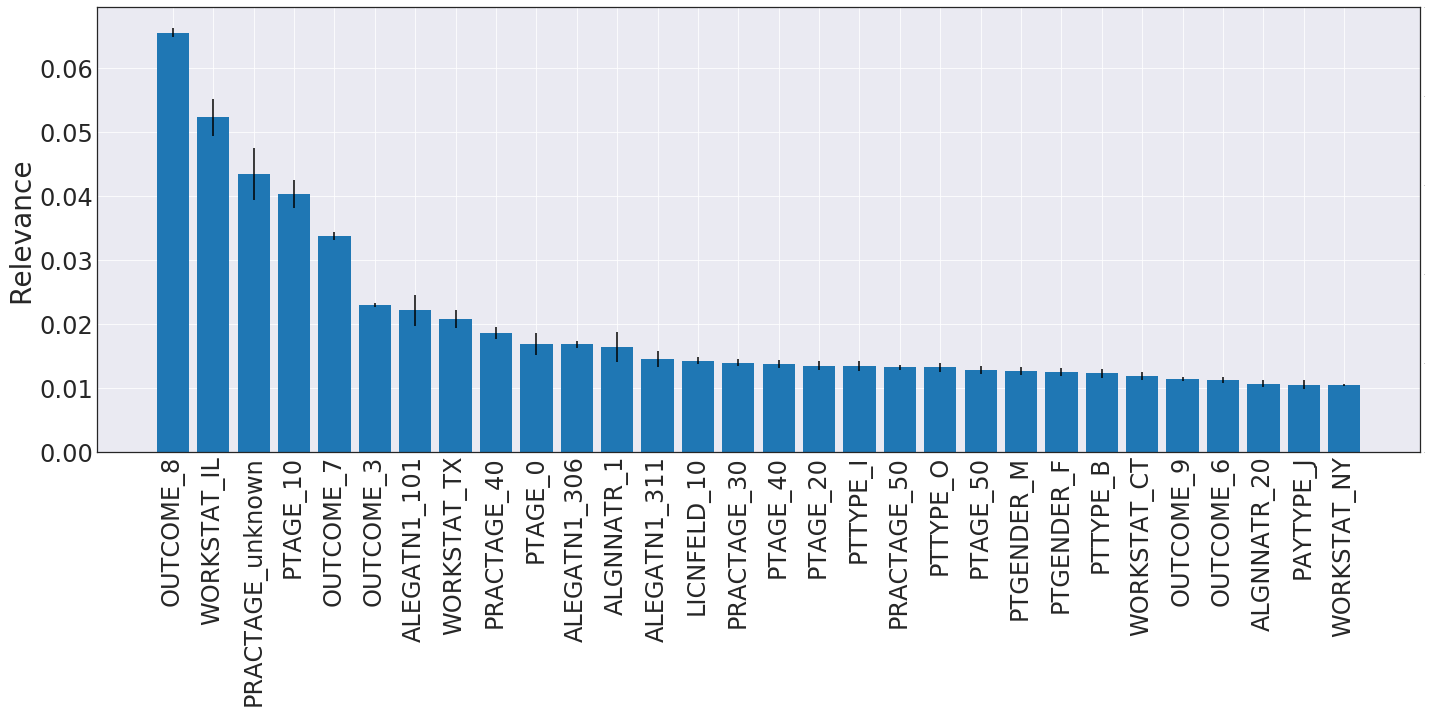

In [20]:
sns.set_style("darkgrid")

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.bar(range(X.shape[1])[:30],importances[indices][:30],yerr=std[indices][:30], align="center") #,color=current_palette[6]
#ax1.set_xlabel('Features',fontsize=30)
plt.xticks(range(X.shape[1])[:30], features[:30],rotation='vertical')
ax1.tick_params(axis='x',labelsize=24)
ax1.set_ylabel('Relevance',fontsize=28)
ax1.tick_params(axis='y',labelsize=24)

sns.set_style("white")
ax2 = ax1.twinx()
#ax2.plot(years,[pay/1000. for pay in payments],color=current_palette[6],marker='o',markersize=12,linewidth=4)
#ax2.set_ylabel('Average Payout Per Case [$1000]',fontsize=32)
ax2.tick_params(axis='y',labelsize=0) #,labelcolor=current_palette[6]
#ax2.set_ylim(100,350)
fig.tight_layout()
#sns.despine()

#plt.savefig('total_numbers_costs_across_us.jpg',dpi=100)
plt.show()

These results suggest that the greatest determinant of the payout is the severity of the outcome (OUTCOME_8 refers to malpractice cases involving the death of the patient) followed by whether the malpractice case happened in IL, the patient age (PTAGE_10), whether the patient was left with severe permanent damage (OUTCOME_7), etc. Most of the top determinants are related to severity of outcomes of the malpractice event, the state in which the malpractice case took place, the type of allegation being brought against the practitioner (ALEGATN1_101 refers to "Failure to Diagnose"), whether the patient was an inpatient, outpatient, or both (PTTYPE), etc.

These results will not be presented as analysis in the website, the estimator model is more relevant to potential users. In the next cell, you can see how well the model is performing in predicting the payout for our training set.

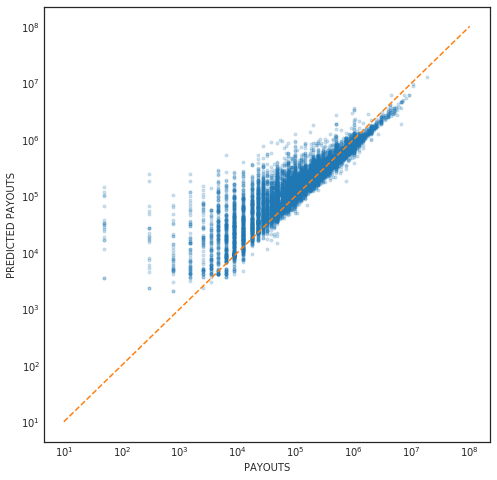

/home/derya/anaconda2/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:116: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/derya/anaconda2/lib/python2.7/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in sqrt
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


LinregressResult(slope=0.72829265688860056, intercept=84136.74766448891, rvalue=0.95160757709689714, pvalue=nan, stderr=nan)

In [21]:
plt.figure(figsize=(8,8))
plt.plot(y,y_predict,marker='.',linewidth=0, alpha=0.2)
plt.plot([1e1,1e8],[1e1,1e8],linestyle='--')
plt.xlabel('PAYOUTS')
plt.ylabel('PREDICTED PAYOUTS')
plt.yscale('log')
plt.xscale('log')
plt.show()

scipy.stats.linregress(y.values.T,y_predict)

# Census/States Data from the Census Bureau:

We will need some census data in order to be able to calculate certain metrics at the state level, such as the number of malpractice cases per capita. So we import here this data for later use and format it appropriately (most numbers are strings instead of being numeric):

In [22]:
#state_pop = pd.read_excel('nst-est2016-01.xlsx',header=3,skip_footer=5)
col_dtype = {'Census': str, 
             'Estimates Base': str, 
             '2010': int,
             '2011': int,
             '2012': int,
             '2013': int,
             '2014': int,
             '2015': int,
             '2016': int,
             'State Abb': str,
            }
state_pop = pd.read_csv('nst-est2016-01.csv',delimiter=',',header=3,skipfooter=5,index_col=0) #,dtype=col_dtype)

new_index_list = {}
for s_label in state_pop.index:
    try:
        if s_label[0]=='.':
            new_index_list.update({s_label: s_label[1:]})
        else:
            new_index_list.update({s_label: s_label})
    except:
        new_index_list.update({s_label: 'unknown'})

state_pop.rename(index=new_index_list,inplace=True)

/home/derya/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


In [23]:
for i in range(2010,2017):
    state_pop[str(i)] = state_pop[str(i)].transform(lambda x: int(''.join(x.strip().split(',')) ))

In [24]:
state_pop['Census'] = state_pop['Census'].transform(lambda x: int(''.join(x.strip().split(',')) ))
state_pop['Estimates Base'] = state_pop['Estimates Base'].transform(lambda x: int(''.join(x.strip().split(',')) ))

In [25]:
state_pop

,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,State Abb
United States,308745538,308758105,309348193,311663358,313998379,316204908,318563456,320896618,323127513,US
Northeast,55317240,55318353,55388056,55632766,55829059,55988771,56116791,56184737,56209510,NE
Midwest,66927001,66929825,66978602,67153331,67332320,67543948,67726368,67838387,67941429,MW
South,114555744,114563005,114863114,116061801,117299171,118424320,119696311,121039206,122319574,SO
West,71945553,71946922,72118421,72815460,73537829,74247869,75023986,75834288,76657000,WE
Alabama,4779736,4780131,4785492,4799918,4815960,4829479,4843214,4853875,4863300,AL
Alaska,710231,710249,714031,722713,731089,736879,736705,737709,741894,AK
Arizona,6392017,6392301,6408312,6467163,6549634,6624617,6719993,6817565,6931071,AZ
Arkansas,2915918,2916025,2921995,2939493,2950685,2958663,2966912,2977853,2988248,AR
California,37253956,37254522,37332685,37676861,38011074,38335203,38680810,38993940,39250017,CA


# Explaratory Analysis For States:

This part of the analysis was actually done first. For my own ease of use, I moved the estimator model above this. We start at the national level, looking at the broadest trends and later go into finer details.

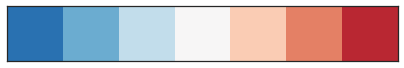

In [26]:
#sns.set_style("ticks")
current_palette = sns.color_palette("RdBu_r", 7) #sns.diverging_palette(220, 10, sep=80, n=7) #sns.color_palette("coolwarm_r", 7) #sns.color_palette("RdBu_r", 7) #sns.diverging_palette(145, 280, s=85, l=25, n=7) #sns.color_palette()
current_palette[0]
sns.palplot(current_palette)
plt.show()

As the data covers the years from 1991 to 2017, we will extract the annual counts of malpractice cases, mean payouts, and the total payout of the US first:

In [27]:
years = range(1990,2018)
counts = [len(data[data['ORIGYEAR']==year]) for year in range(1990,2018)]
payments = [pd.to_numeric(data[data['ORIGYEAR']==year]['PAYMENT']).mean(skipna=True) for year in range(1990,2018)]

In [28]:
total_payments = [pd.to_numeric(data[data['ORIGYEAR']==year]['PAYMENT']).sum(skipna=True) for year in range(1990,2018)]

In [29]:
pickle.dump(years, open("years.pck", "wb"))
pickle.dump(counts, open("counts.pck", "wb"))
pickle.dump(payments, open("payments.pck", "wb"))

Now we're ready to plot the total annual number of malpractice cases, their average payouts over the span of the years 1991 to 2017.

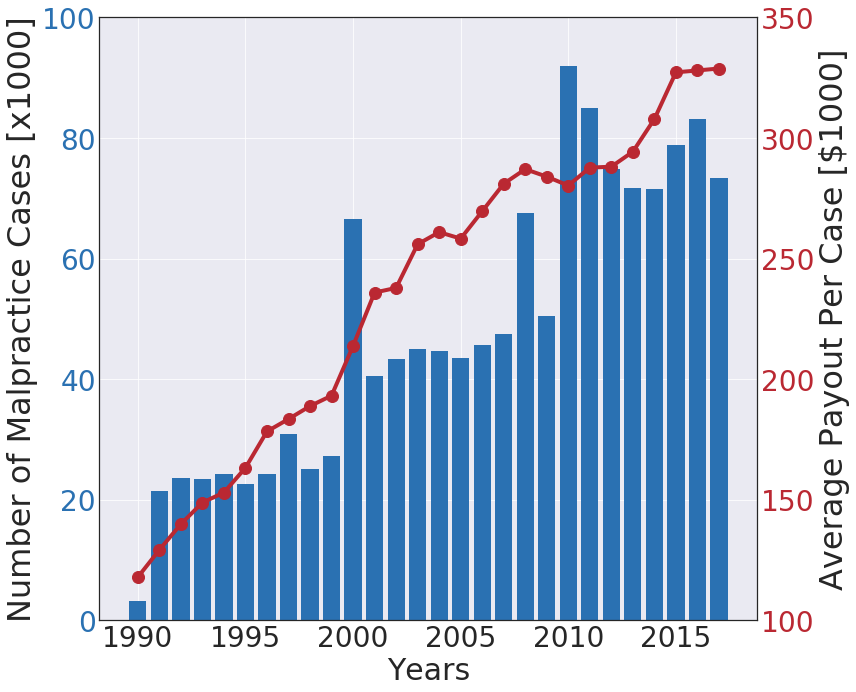

In [30]:
sns.set_style("darkgrid")

fig, ax1 = plt.subplots(figsize=(12,10))

ax1.bar(years,[count/1000. for count in counts],color=current_palette[0])
ax1.set_xlabel('Years',fontsize=30)
ax1.tick_params(axis='x',labelsize=28)
ax1.set_ylabel('Number of Malpractice Cases [x1000]',fontsize=32)
ax1.tick_params(axis='y',labelsize=28,labelcolor=current_palette[0])
ax1.set_ylim(0,100)



sns.set_style("white")
ax2 = ax1.twinx()
ax2.plot(years,[pay/1000. for pay in payments],color=current_palette[6],marker='o',markersize=12,linewidth=4)
ax2.set_ylabel('Average Payout Per Case [$1000]',fontsize=32)
ax2.tick_params(axis='y',labelsize=28,labelcolor=current_palette[6])
ax2.set_ylim(100,350)


fig.tight_layout()
#sns.despine()

plt.savefig('total_numbers_costs_across_us.jpg',dpi=100)
plt.show()

We can also plot another similar graph, but with the total payout across the US instead of the average payouts:

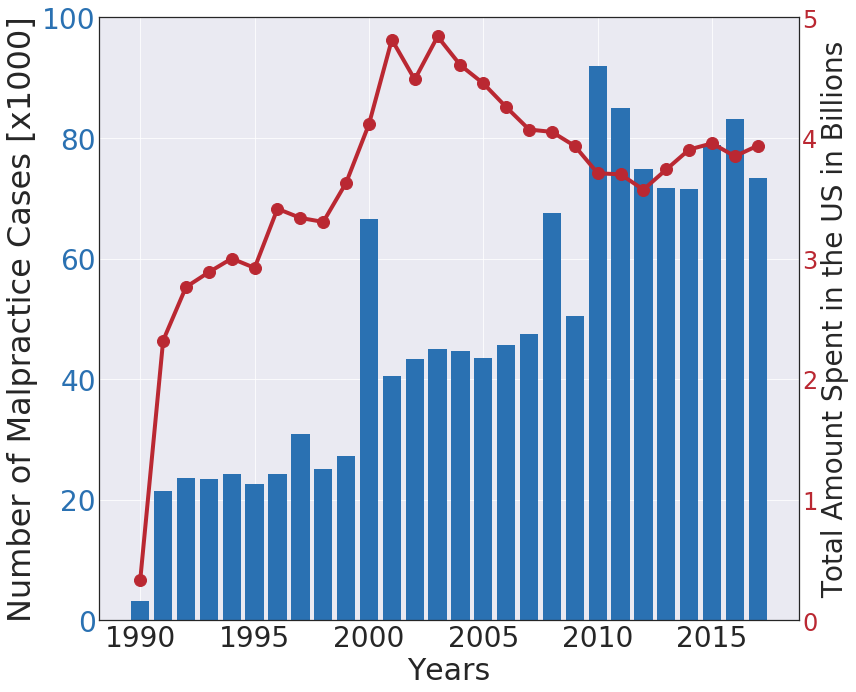

In [31]:
sns.set_style("darkgrid")

fig, ax1 = plt.subplots(figsize=(12,10))

ax1.bar(years,[count/1000. for count in counts],color=current_palette[0])
ax1.set_xlabel('Years',fontsize=30)
ax1.tick_params(axis='x',labelsize=28)
ax1.set_ylabel('Number of Malpractice Cases [x1000]',fontsize=32)
ax1.tick_params(axis='y',labelsize=28,labelcolor=current_palette[0])
ax1.set_ylim(0,100)



sns.set_style("white")
ax2 = ax1.twinx()
ax2.plot(years,[pay/1000000000. for pay in total_payments],
         color=current_palette[6],marker='o',markersize=12,linewidth=4)
ax2.set_ylabel('Total Amount Spent in the US in Billions',fontsize=28)
ax2.tick_params(axis='y',labelsize=24,labelcolor=current_palette[6])
ax2.set_ylim(0,5)


fig.tight_layout()
#sns.despine()

plt.savefig('total_payout_across_us.jpg',dpi=100)
plt.show()

What we see is that the number of malpractice cases and their average payouts have been increasing in the last three decades. In the case of the payouts, this increase has been much larger than the rate of inflation. We also see from the total of the malpractice payouts in the US that it has perhaps reached a moment of saturation over the last 8 years.

Next let's take a closer look at how each state performed in terms of the number of malpractice cases per year:

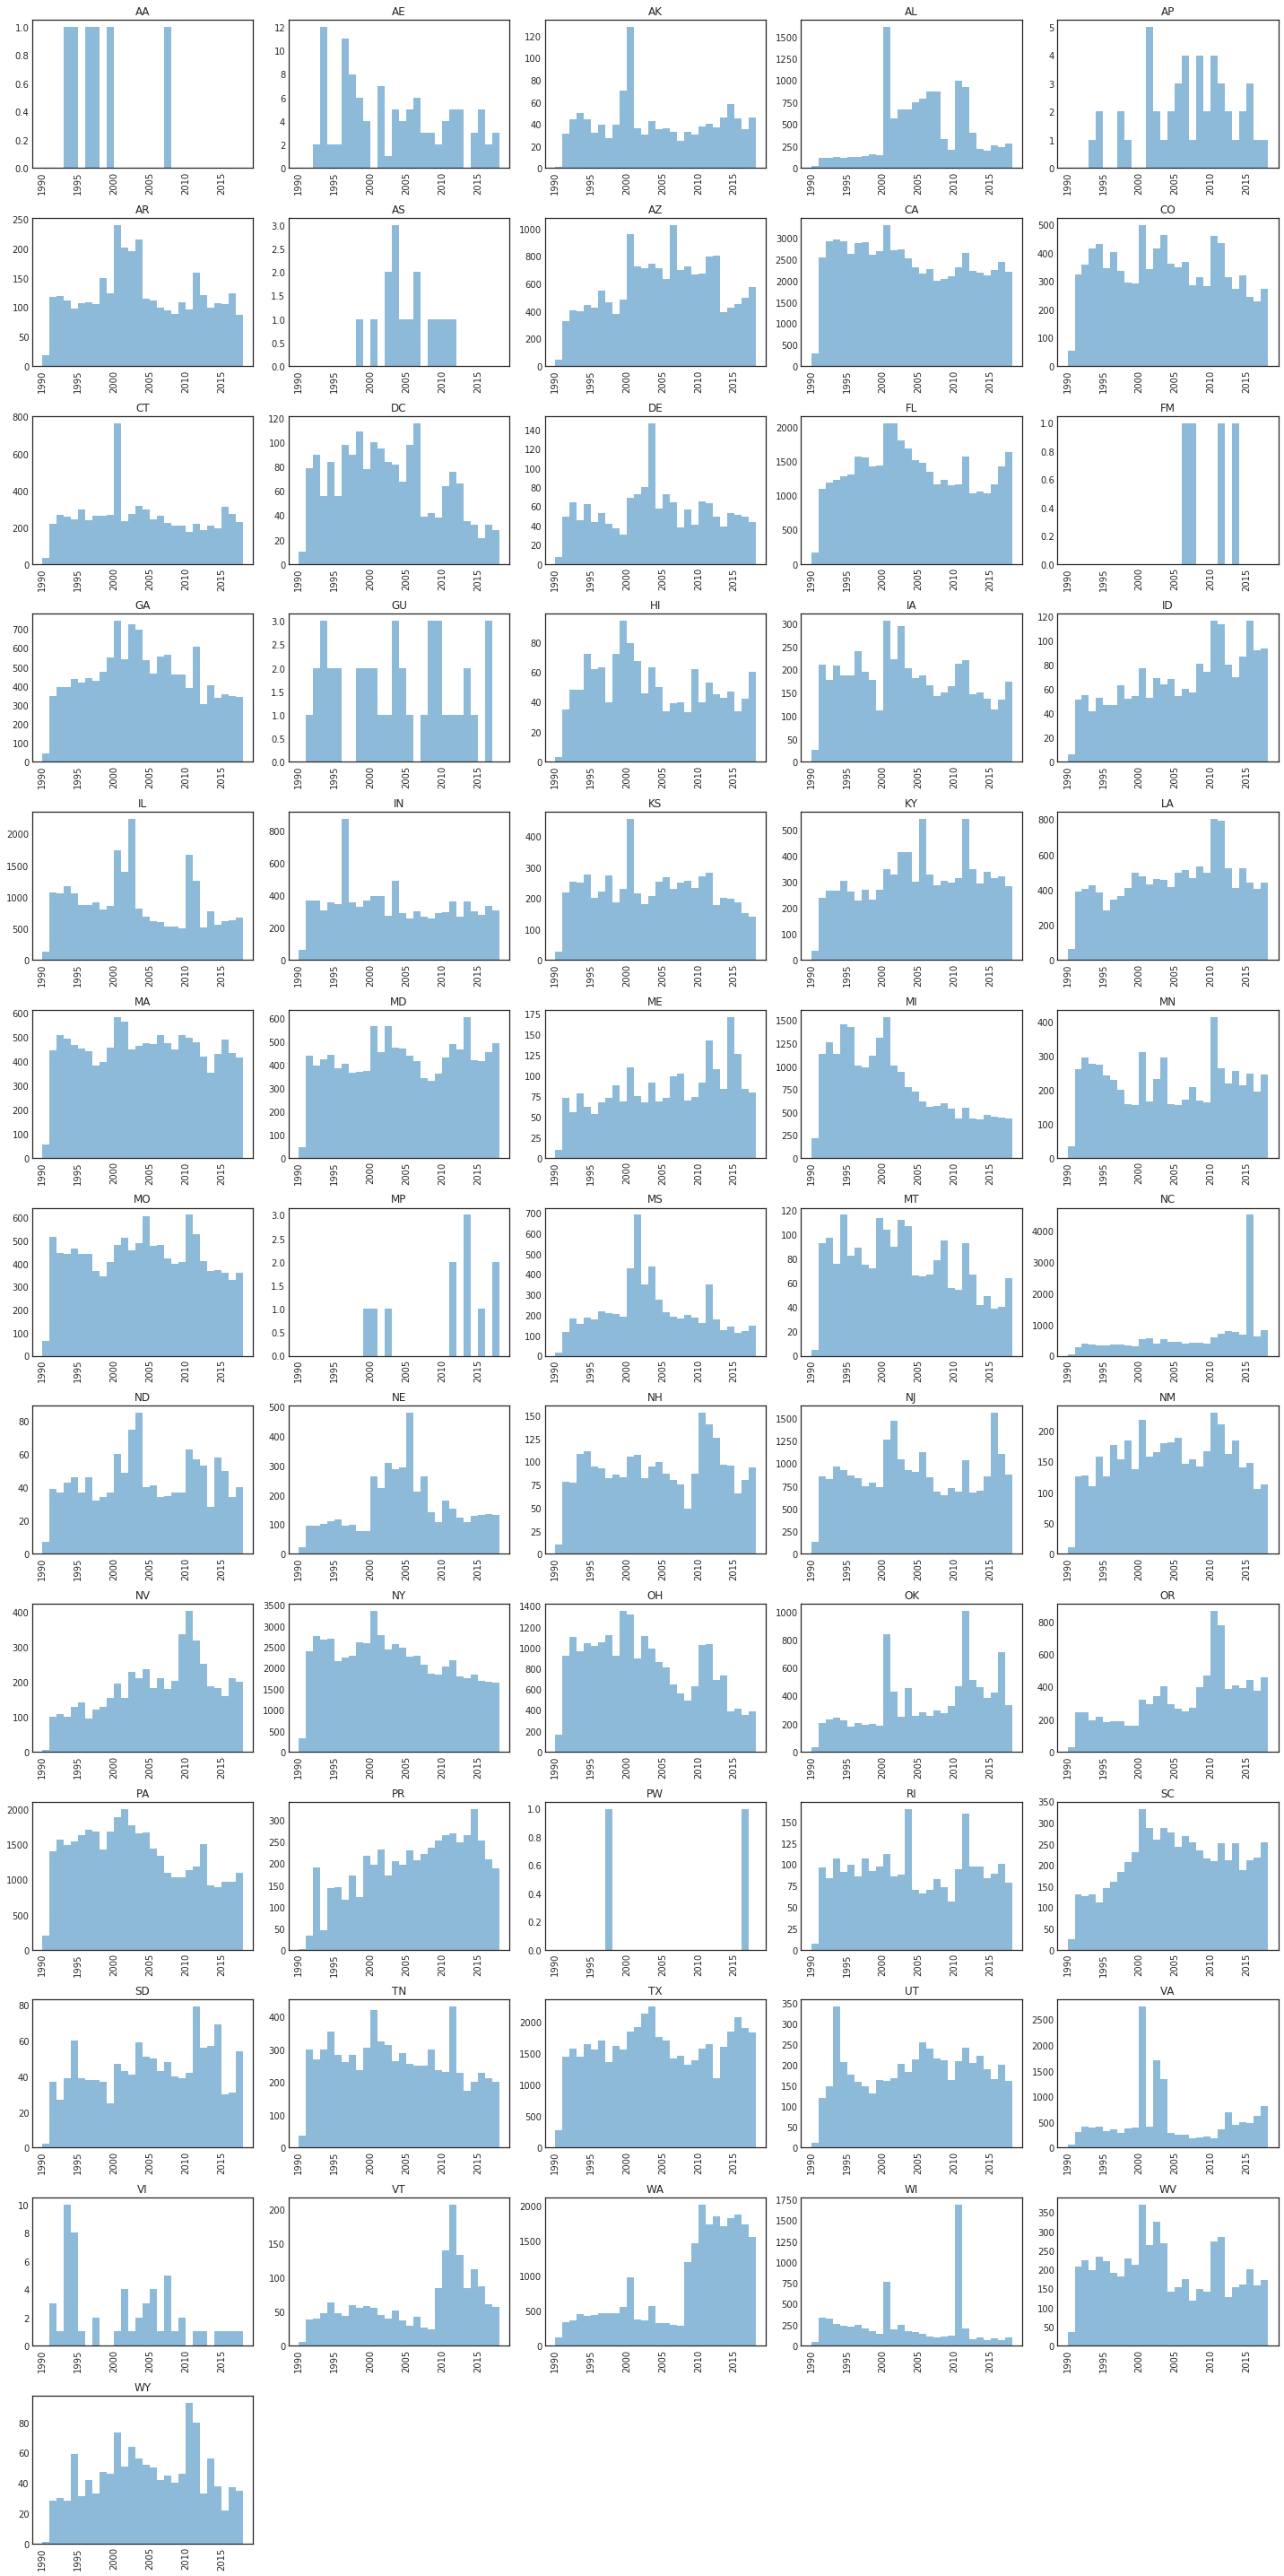

In [32]:
data.hist(column='ORIGYEAR',bins=2018-1990,range=(1990,2018),alpha=0.5,by='WORKSTAT',figsize=(20,40),layout=(13,5))
plt.xlabel('Years')
plt.ylabel('Total Cases')
plt.tight_layout()
plt.show()

The states reveal very different trends. While some states have been able to reduce the number of malpractice cases per year in the last 3 decades, some have seen significant increases. We would like to able to analyze these trends in order to be able to make clear statements about how successful a state has been in reducing the burden of medical malpractice cases on institutions and practitioners.

For this purpose we will look at the three metrics we looked at at the national level: the annual number of malpractice cases per capita per state, the mean payout for each state, and the total payout for each state on a year-by-year basis. We will perform a linear regression analysis to get a very coarse estimate of the rates of change for these three metrics.

Since census data and the NPDB dataset include different sets of states, we will limit this analysis to the intersection of the two lists of states:

In [33]:
common_states = np.intersect1d(list(data["WORKSTAT"].unique()),list(state_pop["State Abb"]))

In [34]:
print(common_states,len(common_states))

(array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'],
      dtype='|S3'), 52)


We now create a new dataframe which will include these 3 metrics for each state for each year between 1990 and 2018:

In [35]:
pay_count = None
for state in common_states:
    #print(state)
    arrays = [[state,state,state], ['pay_per_case', 'count_per_1000000','total_pay']]
    column_names = pd.MultiIndex.from_arrays(arrays).T
    mean_payment = [pd.to_numeric(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)]['PAYMENT']).mean() for i in range(1990,2018)]
    count_per_capita = [1000000.0*len(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)])/state_pop[state_pop["State Abb"]==state]["2016"][0] for i in range(1990,2018)]
    total_pay = [pd.to_numeric(data[(data["WORKSTAT"]==state) & (data["ORIGYEAR"]==i)]['PAYMENT']).sum() for i in range(1990,2018)]
    stack = pd.DataFrame(np.stack((mean_payment,
                                   count_per_capita,
                                   total_pay),axis=0).T,
                         columns=column_names,
                         index=range(1990,2018))
    #print(stack)
    if type(pay_count)==None:
        pay_count = stack
    else:
        pay_count = pd.concat([pay_count, stack], axis=1)

In [36]:
pay_count

AK                                           AL  \
       pay_per_case count_per_1000000   total_pay   pay_per_case   
1990            NaN          1.347901         0.0  166966.666667   
1991  196140.625000         41.784945   3138250.0  121558.333333   
1992  105808.333333         59.307664   3174250.0  217455.555556   
1993  130986.764706         67.395073   4453550.0  230903.448276   
1994   85071.428571         59.307664   2382000.0  254741.666667   
1995  178137.500000         43.132846   3562750.0  281157.894737   
1996  151242.857143         52.568157   5293500.0  405196.236559   
1997  158375.000000         36.393339   3167500.0  225808.988764   
1998  286718.750000         52.568157   6881250.0  296460.674157   
1999  270546.296296         94.353102   7304750.0  274947.887324   
2000  159310.344828        172.531386   4620000.0  367873.529412   
2001  240925.000000         48.524452   7227750.0  244472.727273   
2002  210240.384615         40.437044   5466250.0  233686.781609   
2003  241908.333333         57.959762   7257250.0  212584.027778   
2004  189822.000000         47.176551   4745550.0  211181.818182   
2005  737932.692308         48.524452  19186250.0  223898.305085   
2006  187931.818182         44.480748   4134500.0  281934.375000   
2007  482916.666667         33.697536   5795000.0  182864.912281   
2008  193289.473684         44.480748   3672500.0  310454.545455   
2009  229140.625000         40.437044   3666250.0  306960.000000   
2010  615511.904762         51.220255  12925750.0  282437.500000   
2011  419333.333333         53.916058   6290000.0  250020.833333   
2012  361029.411765         49.872354   6137500.0  317812.500000   
2013  289482.142857         62.003467   4052750.0  454377.659574   
2014  270666.666667         78.178284   4060000.0  637780.172414   
2015  334264.705882         60.655565   5682500.0  308533.653846   
2016  208750.000000         47.176551   2922500.0  426599.000000   
2017  251363.636364         62.003467   5530000.0  402366.071429   

                                               AR                    \
     count_per_1000000   total_pay   pay_per_case count_per_1000000   
1990          4.112434   2504500.0   81357.142857          6.023596   
1991         23.646495   9481550.0   83832.258065         39.488021   
1992         23.440873  15656800.0  226307.065217         39.822665   
1993         26.525199  20088600.0  126375.000000         37.145511   
1994         24.468982  19869850.0  116544.871795         32.795136   
1995         25.497090  21368000.0  107418.354430         35.806934   
1996         25.291469  37683250.0  105860.000000         36.476223   
1997         28.581416  20097000.0   96891.791045         35.472290   
1998         31.871363  26385000.0  178015.789474         49.861993   
1999         30.637633  19521300.0  187451.219512         41.495887   
2000        330.434067  37523100.0  225487.654321         80.314619   
2001        116.998746  24202800.0  169092.233010         67.263494   
2002        137.355294  20330750.0  226741.818182         65.590272   
2003        137.766537  15306050.0  326037.974684         71.948513   
2004        154.421895  16261000.0  261940.229885         38.484088   
2005        163.058006  13210000.0  295718.085106         37.480156   
2006        179.096498  18043800.0  213264.492754         33.464425   
2007        179.918985  10423300.0  259293.103448         31.456559   
2008         67.443917  17075000.0  319433.035714         29.448694   
2009         42.152448  15348000.0  330504.098361         36.476223   
2010        204.593589  14686750.0  291380.434783         32.125848   
2011        190.611313  12001000.0  304291.666667         53.208435   
2012         82.043057  13983750.0  252745.833333         40.157310   
2013         45.236773  21355750.0  309718.181818         33.464425   
2014         41.124339  36991250.0  383099.137931         35.806934   
2015         53.256020  16043750.0  318035.000000         3

### Linear Regression Analysis of the Annual Number of Malpractice Cases per Capita per State, the Mean Payout for Each State, and the Total Payout for Each State:

Here we perform linear regression over the 3 metrics for each state and collect the values of slopes for each fit in order to understand whether a state has successfully diminished these metrics over the last 3 decades.

In [37]:
state_slope = []
for state in common_states:
    slope1, intercept1, rvalue1, pvalue1, stderr1 = scipy.stats.linregress(range(1991,2018),
                                                                      pay_count[state,"pay_per_case"][1:])
    slope2, intercept2, rvalue2, pvalue2, stderr2 = scipy.stats.linregress(range(1991,2018),
                                                                      pay_count[state,"count_per_1000000"][1:])
    slope3, intercept3, rvalue3, pvalue3, stderr3 = scipy.stats.linregress(range(1991,2018),
                                                                      pay_count[state,"total_pay"][1:])

    state_slope.append([state,slope1,slope2,slope3])
    
df_state_slope=pd.DataFrame(state_slope,columns=["state","slope_pay_per_case","slope_count_per_1000000","slope_total_pay"])
df_state_slope #.sort_values("slope")

,state,slope_pay_per_case,slope_count_per_1000000,slope_total_pay
0,AK,8321.941851,-0.203255,6.754667e+04
1,AL,7108.157358,2.025211,-6.274377e+04
2,AR,10004.046375,-0.317074,2.903926e+05
3,AZ,8321.170539,0.962205,9.005864e+05
4,CA,4825.125569,-0.782451,2.424531e+05
5,CO,9293.988498,-0.664984,5.577813e+05
6,CT,14683.618435,-0.742375,1.097702e+06
7,DC,3311.312423,-3.223822,-6.302341e+05
8,DE,10083.690040,-0.160951,-1.967924e+04
9,FL,2107.915479,-0.289428,-4.791743e+05


### Plot of the United States colored according to the slopes of the 3 metrics:

Now using the slopes obtained from our linear regression analysis, we will plot each state and color it according to the slopes of the 3 metrics for the last 3 decades. This plot will be an interactive plot (as seen on the main page of the web application) where the user can toggle between the 3 metrics. Hovering over the plot will present a box including all 3 values for each state. We are excluding HI and AK to maintain a reasonable aspect ratio of the map.

In [38]:
from bokeh.io import show, save, output_notebook 
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    ContinuousColorMapper,
    LabelSet,
    Label,
    LogColorMapper, 
    LogTicker, 
    FixedTicker,
    BasicTicker,
    #LinearTicker,
    ContinuousTicker,
    ColorBar, 
    LinearColorMapper,
    Legend
)
from bokeh.plotting import figure, output_file, show
## This is where we get the state data from:
from bokeh.sampledata.us_states import data as states
from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.palettes import Viridis256 as palette

try:
    del states["HI"]
    del states["AK"]
except:
    pass

#palette.reverse()

states = {
    code: state for code, state in states.items()
}
#print(states)

state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]
state_names = [state['name'] for state in states.values()]

slope_pay_per_case = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    slope_pay_per_case.append(float(df_state_slope[df_state_slope["state"]==abbr]["slope_pay_per_case"]))
    
slope_count_per_1000000 = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    slope_count_per_1000000.append(float(df_state_slope[df_state_slope["state"]==abbr]["slope_count_per_1000000"]))
    
slope_total_pay = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    slope_total_pay.append(float(df_state_slope[df_state_slope["state"]==abbr]["slope_total_pay"]))
    
state_abbr = []
for name in state_names:
    abbr = state_pop.loc[name]["State Abb"]
    state_abbr.append(abbr)
    
#print(state_rates)

lat_inkm = 111.132 ## at around lat = 45degrees from the wiki latitude page
lon_inkm = 78.847 ## at around lat = 45degrees from the wiki latitude page

In [39]:
#from bokeh.palettes import Viridis256 as palette
from bokeh.palettes import RdYlBu11 as palette

from bokeh.palettes import Category20
from bokeh.layouts import column
from bokeh.models import *
from bokeh.plotting import Figure, output_file, show
from bokeh.io import output_notebook, reset_output

#output_notebook()

color_mapper = LinearColorMapper(palette=palette) #, low=min(slope_count_per_1000000), high=max(slope_count_per_1000000))

source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    name=state_names,
    #clusters=state_clusters,
    #cluster_label=cluster_label,
    slopes1=slope_pay_per_case,
    slopes2=slope_count_per_1000000,
    slopes3=slope_total_pay,
))

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(#title="Change in the number of malpractice cases filed per a million citizens per states, 1990-2018", 
    plot_width=int((max(max(state_xs))-min(min(state_xs)))*lon_inkm/4.5), 
    plot_height=int((max(max(state_ys))-min(min(state_ys)))*lat_inkm/4.5), tools=TOOLS,
    x_axis_location=None, y_axis_location=None
)

p.grid.grid_line_color = None

mypatches = p.patches('x', 'y', source=source,
          fill_color={'field': 'slopes2', 'transform': color_mapper},
          fill_alpha=0.7, line_color="gray", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0),major_label_text_font_size="14pt")

p.add_layout(color_bar, 'right')
#HoverTool(tooltips=None, callback=callback, renderers=[cr])
hover = p.select_one(HoverTool) #(tooltips=None, callback=callback, renderers=[mypatches]))
hover.point_policy = "follow_mouse"
hover.tooltips ="""
    <font size="3">State: <strong>@name</strong> </font> <br>
    <font size="3"><strong>Changes in:</strong> </font> <br>
    <font size="3">state payout: <strong>$@slopes3</strong> </font> <br>
    <font size="3">prevalence: <strong>@slopes2 cases per million</strong> </font> <br>
    <font size="3">mean cost: <strong>$@slopes1 </strong> </font>
"""
#output_notebook()
callback = CustomJS(args=dict(source=source, patches=mypatches), code="""
    var selected_slopes = cb_obj.value;
    patches.glyph.fill_color.field = selected_slopes;
    source.change.emit();
""")

#slider = Slider(start=0.1, end=4, value=1, step=.1, title="power")
# slider = Slider(start=0.1, end=4, value=1, step=.1, title="power", callback=callback)
#slider.js_on_change('value', callback)

menu = [("mean state payout ($)", "slopes1"), 
        ("number of cases per million", "slopes2"), 
        ("total state payout ($)", "slopes3")]
dropdown = Dropdown(menu=menu, label="Select option to see change in...")

dropdown.js_on_change('value', callback)

layout = column(dropdown, p)

show(layout)

# State-by-state analysis of malpractice trends:

In this part, the main goal is to be able to present users with plots of any state of their choosing for any of the 3 metrics we have been studying. But we would like to be able to also show other states whose trends have been similar to that state. For this, we create a distance matrix for each metric by taking the square differences between states and using the DBSCAN method to cluster them. In this way, we're able to present the user, say, with the trends belonging to the state of Illinois along with several other examples which have shown the same trend of increase or decrease in the annual number of malpractice cases over the past 27 years.

In [43]:
correlation_slope1 = np.zeros((len(common_states),len(common_states)))
correlation_slope2 = np.zeros((len(common_states),len(common_states)))
correlation_slope3 = np.zeros((len(common_states),len(common_states)))

for state1 in range(len(common_states)):
    for state2 in range(len(common_states)):
        #print(float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"]))
        #print(float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"]))
        #correlation_slope[state1,state2] = np.sqrt(((
        #    float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope"])-
        #    float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope"])))**2)
        correlation_slope1[state1,state2] = ((
            float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope_pay_per_case"])-
            float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope_pay_per_case"])))**2
        correlation_slope2[state1,state2] = ((
            float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope_count_per_1000000"])-
            float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope_count_per_1000000"])))**2
        correlation_slope3[state1,state2] = ((
            float(df_state_slope[df_state_slope["state"]==common_states[state1]]["slope_total_pay"])-
            float(df_state_slope[df_state_slope["state"]==common_states[state2]]["slope_total_pay"])))**2

In [44]:
from sklearn.cluster import DBSCAN
# Compute DBSCAN

def clusters(correlations, epsval=0.05):
    db = DBSCAN(eps=epsval, min_samples=1,metric='precomputed').fit_predict(correlations)
    #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    #core_samples_mask[db.core_sample_indices_] = True
    for i in np.unique(db):
        print(i,common_states[np.where(db==i)])
    print len(np.unique(db))
    return db


db1 = clusters(correlation_slope1,epsval=380000.0)
db2 = clusters(correlation_slope2,epsval=0.05)
db3 = clusters(correlation_slope3,epsval=20000000000.0)

(0, array(['AK', 'AL', 'AZ', 'IA', 'IN', 'KY', 'MO', 'MT', 'NE', 'OH', 'TN',
       'UT'],
      dtype='|S3'))
(1, array(['AR', 'CO', 'DE', 'GA', 'ID', 'MD', 'NJ', 'NM', 'NY', 'PA', 'VA',
       'VT', 'WA', 'WY'],
      dtype='|S3'))
(2, array(['CA', 'LA', 'MI', 'NC', 'ND', 'SC', 'SD', 'WI'],
      dtype='|S3'))
(3, array(['CT'],
      dtype='|S3'))
(4, array(['DC', 'FL', 'MS', 'NV', 'OK', 'WV'],
      dtype='|S3'))
(5, array(['HI', 'ME', 'OR', 'RI'],
      dtype='|S3'))
(6, array(['IL'],
      dtype='|S3'))
(7, array(['KS', 'PR', 'TX'],
      dtype='|S3'))
(8, array(['MA'],
      dtype='|S3'))
(9, array(['MN'],
      dtype='|S3'))
(10, array(['NH'],
      dtype='|S3'))
11
(0, array(['AK', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'IA',
       'IN', 'KS', 'KY', 'MA', 'MD', 'MN', 'MO', 'MS', 'ND', 'NE', 'NH',
       'NJ', 'NM', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'WI', 'WY'],
      dtype='|S3'))
(1, array(['AL', 'NV', 'PR'],
      dtype='|S3'))
(2, array(['DC'],
      

In [45]:
df_state_cluster = pd.DataFrame(np.column_stack((db1,db2,db3)),columns=["cluster_slope_pay_per_case",
                                                             "cluster_slope_count_per_1000000",
                                                             "cluster_slope_total_pay"])
df_state_slope_cluster = pd.concat([df_state_slope,df_state_cluster],axis=1)
df_state_slope_cluster

,state,slope_pay_per_case,slope_count_per_1000000,slope_total_pay,cluster_slope_pay_per_case,cluster_slope_count_per_1000000,cluster_slope_total_pay
0,AK,8321.941851,-0.203255,6.754667e+04,0,0,0
1,AL,7108.157358,2.025211,-6.274377e+04,0,1,0
2,AR,10004.046375,-0.317074,2.903926e+05,1,0,1
3,AZ,8321.170539,0.962205,9.005864e+05,0,0,1
4,CA,4825.125569,-0.782451,2.424531e+05,2,0,1
5,CO,9293.988498,-0.664984,5.577813e+05,1,0,1
6,CT,14683.618435,-0.742375,1.097702e+06,3,0,1
7,DC,3311.312423,-3.223822,-6.302341e+05,4,2,0
8,DE,10083.690040,-0.160951,-1.967924e+04,1,0,0
9,FL,2107.915479,-0.289428,-4.791743e+05,4,0,0


In [46]:
step1 = pd.merge(df_state_slope_cluster,
         pd.DataFrame(df_state_slope_cluster.groupby(["cluster_slope_pay_per_case"])["slope_pay_per_case"].mean()), 
         how='left',on="cluster_slope_pay_per_case")

step2 = pd.merge(step1,
         pd.DataFrame(df_state_slope_cluster.groupby(["cluster_slope_count_per_1000000"])["slope_count_per_1000000"].mean()), 
         how='left',on="cluster_slope_count_per_1000000")

df_state_slope_clusters = pd.merge(step2,
                                     pd.DataFrame(df_state_slope_cluster.groupby(["cluster_slope_total_pay"])["slope_total_pay"].mean()), 
                                     how='left',on="cluster_slope_total_pay")

In [47]:
df_state_slope_clusters
df_state_slope_clusters.rename(index=str, columns={"slope_pay_per_case_x": "slope_pay_per_case", 
                                                   "slope_count_per_1000000_x": "slope_count_per_1000000",
                                                   "slope_total_pay_x": "slope_total_pay",
                                                   "slope_pay_per_case_y": "avg_slope_pay_per_case", 
                                                   "slope_count_per_1000000_y": "avg_slope_count_per_1000000",
                                                   "slope_total_pay_y": "avg_slope_total_pay"}, inplace=True)
df_state_slope_clusters

,state,slope_pay_per_case,slope_count_per_1000000,slope_total_pay,cluster_slope_pay_per_case,cluster_slope_count_per_1000000,cluster_slope_total_pay,avg_slope_pay_per_case,avg_slope_count_per_1000000,avg_slope_total_pay
0,AK,8321.941851,-0.203255,6.754667e+04,0,0,0,7639.704163,-0.128846,-1.827306e+05
1,AL,7108.157358,2.025211,-6.274377e+04,0,1,0,7639.704163,1.949438,-1.827306e+05
2,AR,10004.046375,-0.317074,2.903926e+05,1,0,1,10521.874767,-0.128846,5.177296e+05
3,AZ,8321.170539,0.962205,9.005864e+05,0,0,1,7639.704163,-0.128846,5.177296e+05
4,CA,4825.125569,-0.782451,2.424531e+05,2,0,1,4971.149983,-0.128846,5.177296e+05
5,CO,9293.988498,-0.664984,5.577813e+05,1,0,1,10521.874767,-0.128846,5.177296e+05
6,CT,14683.618435,-0.742375,1.097702e+06,3,0,1,14683.618435,-0.128846,5.177296e+05
7,DC,3311.312423,-3.223822,-6.302341e+05,4,2,0,2961.592965,-3.223822,-1.827306e+05
8,DE,10083.690040,-0.160951,-1.967924e+04,1,0,0,10521.874767,-0.128846,-1.827306e+05
9,FL,2107.915479,-0.289428,-4.791743e+05,4,0,0,2961.592965,-0.128846,-1.827306e+05


The above dataframe will now allow us to plot the trends for these 3 metrics for any state alongside any states which behave similarly for that particular metric within the same time frame:

In [49]:
def create_plot(state,metric):
    mn = ["pay_per_case","count_per_1000000","total_pay"][metric]
    if metric==0:
        y_ax_label = 'Average Payout of Malpractice Cases'
    elif metric==1:
        y_ax_label = 'Malpractice Cases Filed Per Million'
    elif metric==2:
        y_ax_label = 'Total of Malpractice Payout of State'
    #print(state,mn)
    p = figure(plot_width=500, plot_height=500, x_axis_label='Years', y_axis_label=y_ax_label)
    p.xaxis.axis_label_text_font_size = "15pt"
    p.yaxis.axis_label_text_font_size = "15pt"
    rank = int(df_state_slope_clusters[df_state_slope_clusters['state']==state]['cluster_slope_'+mn])
    cur_states = list(df_state_slope_clusters[df_state_slope_clusters["cluster_slope_"+mn]==rank]["state"])
    states_title = str()
    #print(cur_states)
    for x in cur_states:
        states_title = states_title+x+', '
    if len(cur_states)>4:
        sel_states = list(np.random.choice(cur_states,size=4,replace=False))
        sel_states.sort()
        if state in sel_states:
            sel_states.pop(sel_states.index(state))
            cur_states = [state]+sel_states
            #print('if',cur_states)
        else:
            cur_states = [state]+sel_states[:3]
            #print('else',cur_states)
        states_title = str()
        for x in cur_states:
            states_title = states_title+x+', '
        p.title.text = states_title[:-2]+" among others."
    else:
        p.title.text = states_title[:-2]+"."
    
    for state_, color in zip(cur_states, Category20[20]):
        curve = pay_count[state_,mn]
        #plt.plot(range(1990,2018),curve,label=state,marker='.')
        r = p.line(curve.index, curve,line_width=2, color=color, alpha=1.,
                   muted_color=color, muted_alpha=0.2, legend=state_)
        if state_!=state:
            r.muted=True
    p.legend.location = "top_right"
    p.legend.click_policy="mute"
    return(p)

#output_notebook()
from bokeh.layouts import column, row

plot_mini1 = create_plot("GA",0)
plot_mini2 = create_plot("GA",1)
plot_mini3 = create_plot("GA",2)
layoutx = row([plot_mini1,plot_mini2,plot_mini3])

show(layoutx)
#show(plot_mini)

### Medical Error Disclosure Laws:

We now import some information relating to medical error disclosure laws for states from:

https://digitalcommons.law.yale.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1161&context=yjhple

We present an analysis of whether these laws correlate in an rates of change of the 3 metrics we have been studying using boxplots.

In [51]:
non_existent = ["AL", "AK", "AZ", "AR", "DE", "GA", "HI", "ID", "IA", "KY", "LA", "MS", 
                "MO", "MT", "NH", "NM", "NC", "ND", "OK", "SD", "VA", "WV", "WI"] 
mandatory = ["CA", "CO", "CT", "DC", "FL", "IL", "IN", "KS", "ME", "MD", "MA", "MN", 
             "NV", "NJ", "NY", "OH", "PA", "RI", "SC", "TN", "TX", "UT", "VT", "WA"]
partial = ["OR", "WY"]
#no_info = ["PR"]
self_organized = ["MI"]
voluntary = ["NE"]

In [52]:
ordered_mandatory = []
for state in list(df_state_slope_cluster["state"]):
    #print(state)
    if state in non_existent:
        ordered_mandatory.append('No')
    elif state in mandatory:
        ordered_mandatory.append('Yes')
    elif state in partial:
        ordered_mandatory.append('Partially')
    elif state in voluntary:
        ordered_mandatory.append('Voluntary')
    elif state in self_organized:
        ordered_mandatory.append('Self Org.')
    #elif state in no_info:
    #    ordered_mandatory.append('NA')
    else:
        print(state,"ERROR")

('PR', 'ERROR')


In [53]:
slope_mandatory = pd.DataFrame(np.stack([np.array(df_state_slope_cluster["state"].drop([39])),
                                         np.array(df_state_slope_cluster["slope_pay_per_case"].drop([39])), 
                                         np.array(df_state_slope_cluster["slope_count_per_1000000"].drop([39])), 
                                         np.array(df_state_slope_cluster["slope_total_pay"].drop([39])), 
                                         np.array(ordered_mandatory)]).T, columns=['state','slope_pay_per_case',
                                                                                   'slope_count_per_1000000',
                                                                                   'slope_total_pay',
                                                                                   "mandatory"])

In [56]:
df_state_slope_cluster.iloc[39]

state                                   PR
slope_pay_per_case                 484.054
slope_count_per_1000000            1.87411
slope_total_pay                     334754
cluster_slope_pay_per_case               7
cluster_slope_count_per_1000000          1
cluster_slope_total_pay                  1
Name: 39, dtype: object

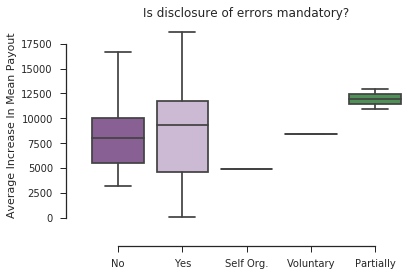

In [57]:
import seaborn as sns
sns.set(style="ticks")

sns.boxplot(x=np.array(ordered_mandatory), 
            y=np.array(df_state_slope_cluster["slope_pay_per_case"].drop([39])), 
            palette="PRGn", width=0.8)

sns.despine(offset=20, trim=True)
plt.title("Is disclosure of errors mandatory?")
plt.ylabel("Average Increase In Mean Payout") #,fontsize=14)
plt.tight_layout()
plt.savefig("Mandatory.png",dpi=300)
plt.show()

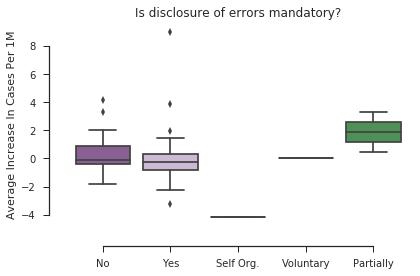

In [59]:
sns.set(style="ticks")

sns.boxplot(x=np.array(ordered_mandatory), 
            y=np.array(df_state_slope_cluster["slope_count_per_1000000"].drop([39])), 
            palette="PRGn", width=0.8)

sns.despine(offset=20, trim=True)
plt.title("Is disclosure of errors mandatory?")
plt.ylabel("Average Increase In Cases Per 1M") #,fontsize=14)
plt.tight_layout()
plt.savefig("Mandatory.png",dpi=300)
plt.show()

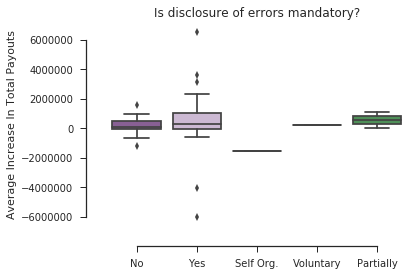

In [61]:
sns.set(style="ticks")

sns.boxplot(x=np.array(ordered_mandatory), 
            y=np.array(df_state_slope_cluster["slope_total_pay"].drop([39])), 
            palette="PRGn", width=0.8)

sns.despine(offset=20, trim=True)
plt.title("Is disclosure of errors mandatory?")
plt.ylabel("Average Increase In Total Payouts") #,fontsize=14)
plt.tight_layout()
plt.savefig("Mandatory.png",dpi=300)
plt.show()

These results do not suggest any strong correlation between state laws on error diclosure and rates of change in relevant metrics regarding medical malpractice trends.

## Most problematic license fields:

The NPDB dataset also provides the field of license of the practitioner for each medical malpractice case. Unfortunately these are fairly broad categories, we do not have information about the medical expertise of the MDs in this dataset. But we can compare MDs, DOs, various nurse qualifications, pharmacists, dentists, etc.

In [63]:
licnfeld = pd.read_csv('LICNFELD.csv',delimiter=',')[["Value","Label"]]
licnfeld_dict = licnfeld.to_dict(orient='split')
#np.array(licnfeld_dict['data'])

In [64]:
licnfeld_dict

{'columns': ['Value', 'Label'],
 'data': [[10, 'Allopathic Physician (MD)'],
  [15, 'Physician Resident (MD)'],
  [20, 'Osteopathic Physician (DO)'],
  [25, 'Osteopathic Physician Resident (DO)'],
  [30, 'Dentist'],
  [35, 'Dental Resident'],
  [50, 'Pharmacist'],
  [55, 'Pharmacy Intern '],
  [60, 'Pharmacist, Nuclear'],
  [70, 'Pharmacy Assistant'],
  [75, 'Pharmacy Technician '],
  [76, 'Other Pharmacy Service Occupation'],
  [100, 'Registered Nurse'],
  [110, 'Nurse Anesthetist'],
  [120, 'Nurse Midwife'],
  [130, 'Nurse Practitioner'],
  [134, 'Doctor of Nursing Practice '],
  [135, 'Advanced Nurse Practitioner '],
  [140, 'LPN or Vocational Nurse'],
  [141, 'Clinical Nurse Specialist '],
  [142, 'Other Nurse Occupation'],
  [148, 'Certified Nurse Aide/Nursing Assistant '],
  [150, 'Nurse Aide/Nursing Assistant'],
  [160, 'Home Health Aide (Homemaker)'],
  [165, 'Health Care Aide/Direct Care Worker '],
  [170, 'Psychiatric Technician'],
  [175, 'Certified or Qualified Medication A

In [65]:
dict_fin = {}
for element in licnfeld_dict['data']:
    dict_fin[element[0]] = element[1]

#print(dict_fin)

In [66]:
clustering_data = data.copy()
clustering_data.replace(to_replace= {'LICNFELD': dict_fin}, inplace=True)

In [68]:
license_state = clustering_data[['LICNFELD','WORKSTAT']]

In [69]:
def license_bar_plot(df,upto=20,save=None):
    lic_list = []
    count = []
    for license in np.unique(df['LICNFELD']):
        lic_list.append(license)
        count.append(len(df[df['LICNFELD']==license]))
    lic_count = pd.DataFrame(np.array(count).T,columns=['count'],index=lic_list)
    lic_count.sort_values('count',inplace=True,ascending=False)
    lic_count[:upto].plot(kind='barh',figsize=(20,15),fontsize=24)
    plt.tight_layout()
    if save!=None:
        plt.savefig(save, dpi=300)
    plt.show()
    return lic_count

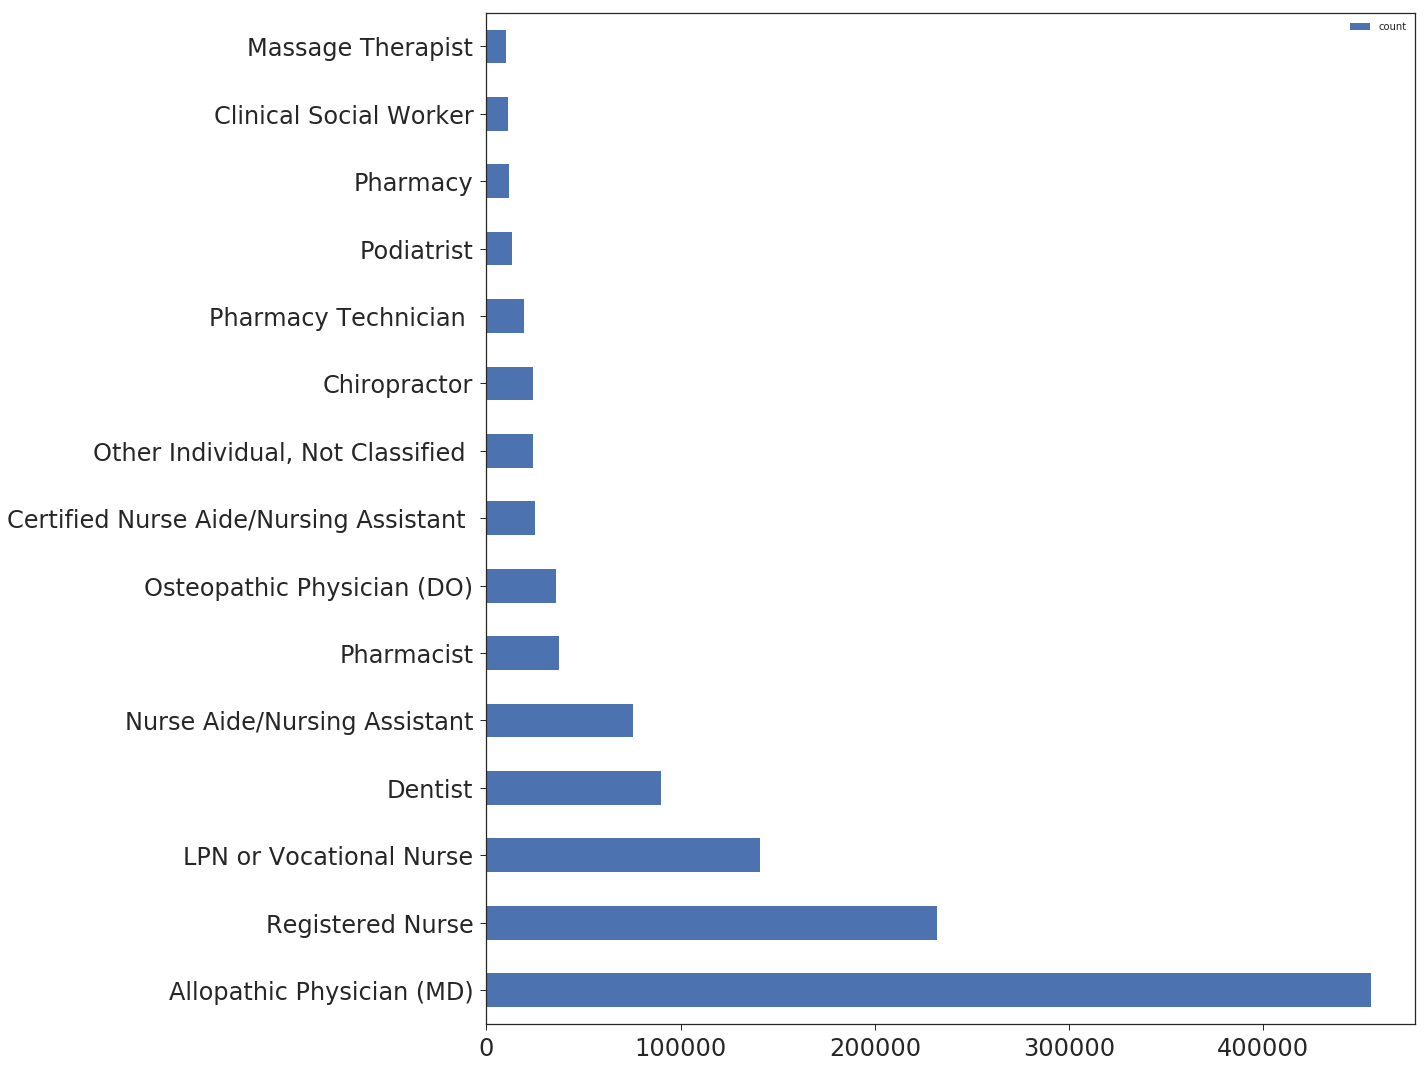

,count
Allopathic Physician (MD),455433
Registered Nurse,231925
LPN or Vocational Nurse,140851
Dentist,89638
Nurse Aide/Nursing Assistant,75341
Pharmacist,37316
Osteopathic Physician (DO),35880
Certified Nurse Aide/Nursing Assistant,25024
"Other Individual, Not Classified",23878
Chiropractor,23819


In [70]:
license_bar_plot(clustering_data,upto=15,save="risky_fields.png")

We can also do this type of analysis for particular states. For example, in the next two cells, we'll create a bar plot of the riskiest fields oflicense in Pennsylvania.

In [71]:
def license_bar_plot_state(state,upto=10,save=None):
    current = license_state[license_state["WORKSTAT"]==state]
    lic_list = []
    count = []
    for license in np.unique(current['LICNFELD']):
        lic_list.append(license)
        count.append(len(current[current['LICNFELD']==license]))
    lic_count = pd.DataFrame(np.array(count).T,columns=['count'],index=lic_list)
    lic_count.sort_values('count',inplace=True,ascending=False)
    lic_count[:upto].plot(kind='barh',figsize=(20,15),fontsize=24)
    plt.tight_layout()
    if save!=None:
        plt.savefig(save, dpi=300)
    plt.show()
    return lic_count

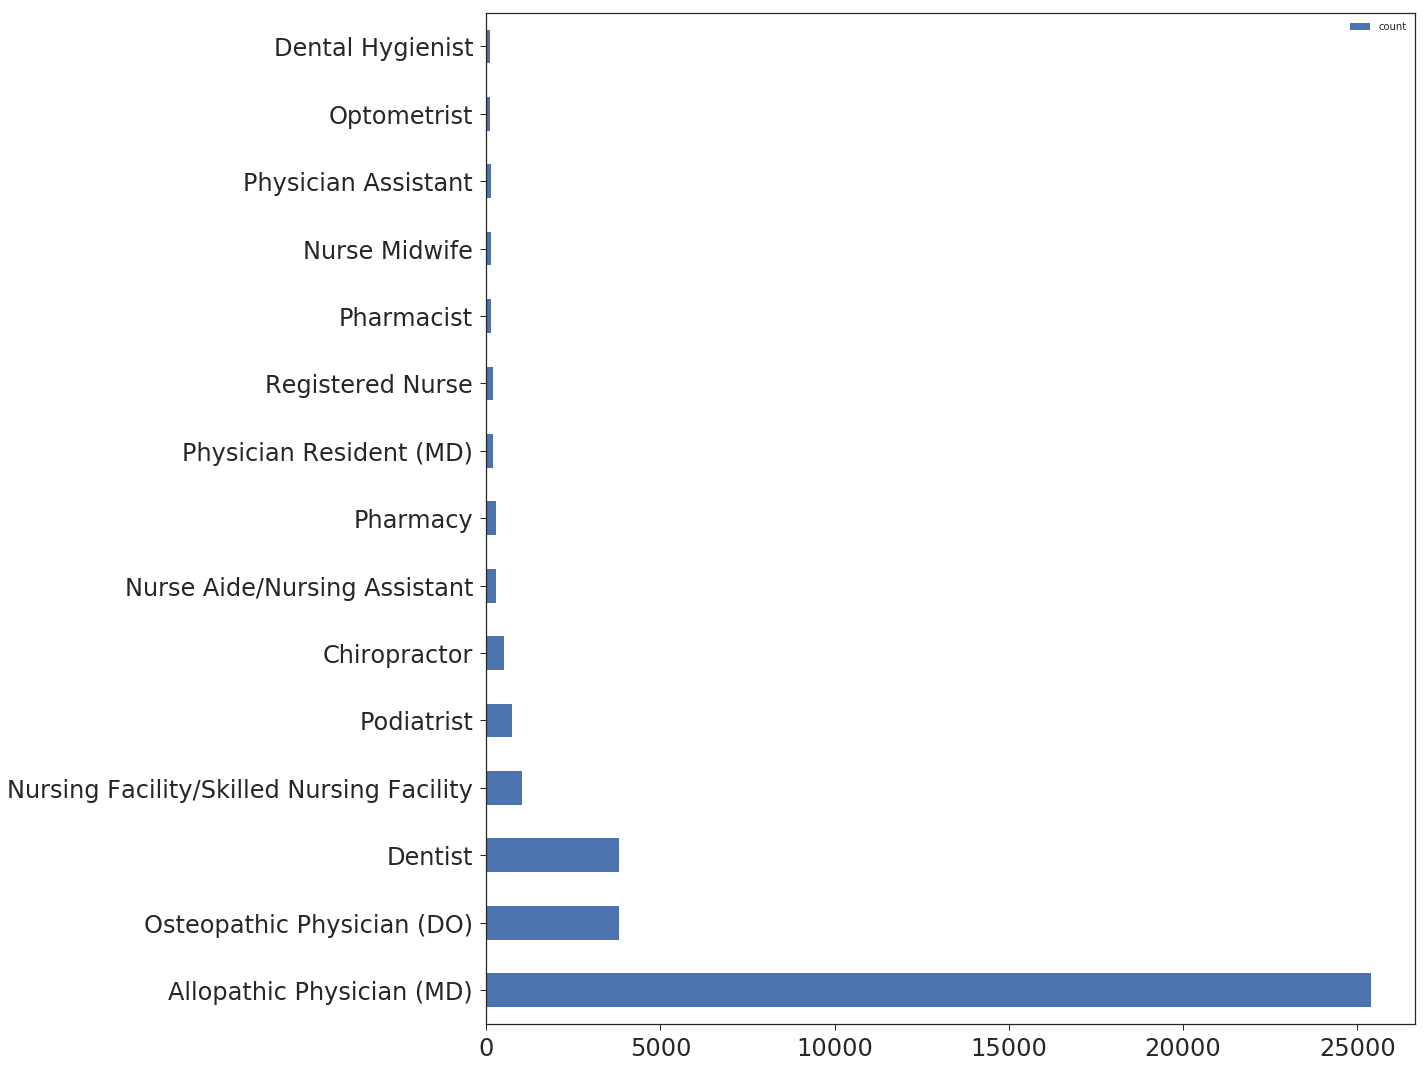

,count
Allopathic Physician (MD),25393
Osteopathic Physician (DO),3806
Dentist,3800
Nursing Facility/Skilled Nursing Facility,1043
Podiatrist,728
Chiropractor,503
Nurse Aide/Nursing Assistant,295
Pharmacy,283
Physician Resident (MD),211
Registered Nurse,190


In [72]:
license_bar_plot_state("PA",upto=15,save="risky_fields_PA.png")

# Adding state specific information for our final analysis of state policies:

We will calculate the MD to DO ratio of states, import their GDPs and overall hospital ratings, caps on payouts and statute of limitation laws on malpractice cases. Later, we will use a random forest regressor model to understand which of these features are the most relevant to determining the average payouts, total number of malpractice cases per capita, and the total payout of states.

#### MD to DO ratios for states:

In [73]:
docs = pd.read_csv('states_MD_vs_DO.csv',header=1)

In [75]:
docs_new_index = {}
for new, old in zip(['state','population','totaldocs','docper100000','rank','mds','mdsper100000','dos','dosper100000'],docs.columns):
    docs_new_index[old] = new
    
docs_new_index

{'Number': 'totaldocs',
 'Number.1': 'mds',
 'Number.2': 'dos',
 'Rank': 'rank',
 'Rate Per 100000': 'docper100000',
 'Rate Per 100000.1': 'mdsper100000',
 'Rate Per 100000.2': 'dosper100000',
 'Total Population': 'population',
 'Unnamed: 0': 'state'}

In [76]:
docs.rename(columns=docs_new_index,inplace=True)

In [78]:
state_abb =  []
for state in docs['state']:
    if state in state_pop.index:
        state_abb.append(state_pop.loc[state]['State Abb'])
    else:
        state_abb.append(state)

#state_abb

In [79]:
docs['state_abb'] = state_abb

In [80]:
docs['ratio'] = docs['mds']/docs['dos']

In [81]:
docs

,state,population,totaldocs,docper100000,rank,mds,mdsper100000,dos,dosper100000,state_abb,ratio
0,United States,313914040,817850,260.5,NaN,759227,241.9,58409,18.6,US,12.998459
1,Alabama,4822023,9681,200.8,44.0,9259,192.0,419,8.7,AL,22.097852
2,Alaska,731449,1813,247.9,25.0,1642,224.5,171,23.4,AK,9.602339
3,Arizona,6553255,15133,230.9,32.0,13391,204.3,1738,26.5,AZ,7.704833
4,Arkansas,2949131,5629,190.9,48.0,5377,182.3,252,8.5,AR,21.337302
5,California,38041430,97977,257.6,20.0,93884,246.8,4063,10.7,CA,23.107064
6,Colorado,5187582,13869,267.3,16.0,12767,246.1,1098,21.2,CO,11.627505
7,Connecticut,3590347,11949,332.8,6.0,11527,321.1,420,11.7,CT,27.445238
8,Delaware,917092,2439,265.9,18.0,2149,234.3,289,31.5,DE,7.435986
9,District of Columbia,632323,5559,879.1,NaN,5435,859.5,122,19.3,DC,44.549180


slopes = []
ratios = []
colors = []

for state in common_states:
    #print state
    slopes.append(float(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor['state']==state]['slope_count_per_1000000']))
    ratios.append(float(docs[docs['state_abb']==state]['ratio']))
    colors.append(int(df_state_slope_cluster_aslope_acolor[df_state_slope_cluster_aslope_acolor['state']==state]['cl_colors']))

#print slopes
#print ratios
#plt.plot(slopes,ratios,marker='.',linewidth=0)
#plt.show()

counts = []
ratios = []

for state in common_states:
    #print state
    counts.append(float(pay_count[state]['count_per_1000000'].loc[1990]))
    ratios.append(float(docs[docs['state_abb']==state]['ratio']))

#print counts
#print ratios
#plt.plot(counts,ratios,marker='.',linewidth=0)
#plt.show()

### GDPs:

In [126]:
gdp = pd.read_csv('GDP_by_state.csv', header=1, skiprows=3)
gdp.drop(labels=[60,61,62,63,64,65], axis=0,inplace=True)
state_abb2 =  []
for state in gdp['Area']:
    if state in state_pop.index:
        state_abb2.append(state_pop.loc[state]['State Abb'])
    else:
        state_abb2.append(state)

#state_abb2
gdp['state_abb']=state_abb2
#gdp

In [127]:
GDP_2013 = []


for state in common_states:
    try:
        #print state
        value = float(gdp[gdp['state_abb']== state]['2013'])
        #print value
        GDP_2013.append(value)
    except:
        GDP_2013.append(np.nan)
#print GDP_2013

#### State hospital ratings:

In [128]:
state_ratings = pd.read_csv('HOSArchive_Revised_Flatfiles_20131001/HCAHPS Measures - State.csv')

In [129]:
for column in state_ratings.columns:
    if 'nurse' in column:
        print column
    if 'doctor' in column:
        print column
    if 'hospital' in column:
        print column

Percent of patients who reported that their nurses 'Sometimes' or 'Never' communicated well.
Percent of patients who reported that their nurses 'Usually' communicated well.
Percent of patients who reported that their nurses 'Always' communicated well.
Percent of patients who reported that their doctors 'Sometimes' or 'Never' communicated well.
Percent of patients who reported that their doctors 'Usually' communicated well.
Percent of patients who reported that their doctors 'Always' communicated well.
Percent of patients at each hospital who reported that YES they were given information about what to do during recovery.
Percent of patients who gave their hospital a rating of 6 or lower on a scale from 0 (lowest) to 10 (highest).
Percent of patients who gave their hospital a rating of 7 or 8 on a scale from 0 (lowest) to 10 (highest).
Patients who gave their hospital a rating of 9 or 10 on a scale from 0 (lowest) to 10 (highest).
Percent of patients who reported NO they would not recomm

hospital_ratings = pd.read_csv('HOSArchive_Revised_Flatfiles_20131001/HCAHPS Measures.csv')

nurses = []
doctors = []

for column in state_ratings.columns:
    if 'nurse' in column:
        print column
        nurses.append(column)
    if 'doctor' in column:
        print column
        doctors.append(column)

#### State Error Disclosure Laws:

In [130]:
non_existent = ["AL", "AK", "AZ", "AR", "DE", "GA", "HI", "ID", "IA", "KY", "LA", "MS", 
                "MO", "MT", "NH", "NM", "NC", "ND", "OK", "SD", "VA", "WV", "WI"] 
mandatory = ["CA", "CO", "CT", "DC", "FL", "IL", "IN", "KS", "ME", "MD", "MA", "MN", 
             "NV", "NJ", "NY", "OH", "PA", "RI", "SC", "TN", "TX", "UT", "VT", "WA"]
partial = ["OR", "WY"]
#no_info = ["PR"]
self_organized = ["MI"]
voluntary = ["NE"]

In [131]:
# non-existent 0
# mandatory 1
# partial 2
# self-organized 3
# voluntary is 4

dict_laws = {}
for i in non_existent:
    dict_laws[i] = (0,'non-existent')
for i in mandatory:
    dict_laws[i] = (1,'mandatory')
for i in partial:
    dict_laws[i] = (2,'partial')
for i in self_organized:
    dict_laws[i] = (3,'self-organized')
for i in voluntary:
    dict_laws[i] = (4,'voluntary')


#### Payout Caps and Statutues of Limitation on Malpractice Cases:

In [132]:
statutes_caps = pd.read_csv('statute_of_limitations_new.csv')

In [133]:
cols_stat_caps = {}
for key, value in zip(statutes_caps.columns,['state',
                                             'time_after_treatment',
                                             'time_after_discovery',
                                             'max_time','cap',
                                             'cap_death_injury']):
    cols_stat_caps[key]=value

In [134]:
statutes_caps.rename(columns=cols_stat_caps,inplace=True)

In [135]:
state_abb3 =  []
for state in statutes_caps['state']:
    if state in state_pop.index:
        state_abb3.append(state_pop.loc[state]['State Abb'])
    else:
        state_abb3.append(state)

#state_abb2
statutes_caps['state_abb']=state_abb3
statutes_caps

,state,time_after_treatment,time_after_discovery,max_time,cap,cap_death_injury,state_abb
0,Alabama,2.0,0.5,4.0,10000000,10000000,AL
1,Alaska,2.0,2.0,100.0,250000,400000,AK
2,Arizona,2.0,2.0,100.0,10000000,10000000,AZ
3,Arkansas,2.0,0.0,2.0,10000000,10000000,AR
4,California,1.0,1.0,3.0,250000,250000,CA
5,Colorado,2.0,2.0,3.0,300000,1000000,CO
6,Connecticut,2.0,2.0,3.0,10000000,10000000,CT
7,Delaware,2.0,1.0,3.0,10000000,10000000,DE
8,District of Columbia,3.0,3.0,100.0,10000000,10000000,DC
9,Florida,2.0,2.0,4.0,500000,1000000,FL


### Finally, we combine all of the above state specific information to a single dataframe:

We are interested here in taking information for the same year (we're using 2013 for state laws and various other metrics here) for all these features in order to analyze their effects on the total number of malpractice cases per capita for each state, the mean payouts, and the total payouts per state in 2013. IMPORTANT NOTE: We are no longer interested in the rates of change. We are looking at the bare values from the year 2013, not the results for the slopes from the earlier linear regression analysis.

In [138]:
## TRY ALL FOR 2013:

list_for_RFR = []
col_names = ['state','gdp','population','md2do',
             'nurses_never','nurses_usually','nurses_always',
             'doctors_never','doctors_usually','doctors_always',
             'error_disc',
             'slope_pay_per_case','slope_count_per_1000000','slope_total_pay',
             'time_after_treatment','time_after_discovery','max_time','cap','cap_death_injury',
             'count','mean_cost','total_cost']

for state in common_states:
    try:
        row = []
        row.append(state)
        row.append(1000000.0*float(gdp[gdp['state_abb']==state]["2013"])/float(state_pop[state_pop['State Abb']==state]["2013"]))
        row.append(float(state_pop[state_pop['State Abb']==state]["2016"]))
        row.append(float(docs[docs['state_abb']==state]["ratio"]))
        for col in nurses:
            row.append(float(state_ratings[state_ratings['State']==state][col]))
        for col in doctors:
            row.append(float(state_ratings[state_ratings['State']==state][col]))
        row.append(dict_laws[state][0])
        row.append(float(df_state_slope_cluster[df_state_slope_cluster['state']==state]['slope_pay_per_case']))
        row.append(float(df_state_slope_cluster[df_state_slope_cluster['state']==state]['slope_count_per_1000000']))
        row.append(float(df_state_slope_cluster[df_state_slope_cluster['state']==state]['slope_total_pay']))
        row.append(float(statutes_caps[statutes_caps['state_abb']==state]['time_after_treatment']))
        row.append(float(statutes_caps[statutes_caps['state_abb']==state]['time_after_discovery']))
        row.append(float(statutes_caps[statutes_caps['state_abb']==state]['max_time']))
        row.append(float(statutes_caps[statutes_caps['state_abb']==state]['cap']))
        row.append(float(statutes_caps[statutes_caps['state_abb']==state]['cap_death_injury']))
        row.append(pay_count[state,'count_per_1000000'].loc[2013])
        row.append(pay_count[state,'pay_per_case'].loc[2013])
        row.append(pay_count[state,'total_pay'].loc[2013])
        list_for_RFR.append(row)
    except:
        print "Issue with state " + state

df_RFR = pd.DataFrame(list_for_RFR,columns=col_names)
df_RFR

Issue with state NE
Issue with state PR


,state,gdp,population,md2do,nurses_never,nurses_usually,nurses_always,doctors_never,doctors_usually,doctors_always,...,slope_count_per_1000000,slope_total_pay,time_after_treatment,time_after_discovery,max_time,cap,cap_death_injury,count,mean_cost,total_cost
0,AK,81163.936006,741894.0,9.602339,4.0,19.0,77.0,4.0,14.0,82.0,...,-0.203255,6.754667e+04,2.0,2.0,100.0,250000.0,400000.0,62.003467,289482.142857,4052750.0
1,AL,39407.770486,4863300.0,22.097852,5.0,15.0,80.0,3.0,11.0,86.0,...,2.025211,-6.274377e+04,2.0,0.5,4.0,10000000.0,10000000.0,45.236773,454377.659574,21355750.0
2,AR,38685.041182,2988248.0,21.337302,5.0,17.0,78.0,4.0,13.0,83.0,...,-0.317074,2.903926e+05,2.0,0.0,2.0,10000000.0,10000000.0,33.464425,309718.181818,17034500.0
3,AZ,40827.869747,6931071.0,7.704833,5.0,19.0,76.0,6.0,17.0,77.0,...,0.962205,9.005864e+05,2.0,2.0,100.0,10000000.0,10000000.0,56.124082,307473.300971,63339500.0
4,CA,58011.744453,39250017.0,23.107064,6.0,20.0,74.0,6.0,16.0,78.0,...,-0.782451,2.424531e+05,1.0,1.0,3.0,250000.0,250000.0,55.566855,200241.532258,248299500.0
5,CO,54452.660916,5540545.0,11.627505,4.0,18.0,78.0,3.0,16.0,81.0,...,-0.664984,5.577813e+05,2.0,2.0,3.0,300000.0,1000000.0,48.912156,295289.024390,36320550.0
6,CT,67011.901825,3576452.0,27.445238,5.0,18.0,77.0,5.0,16.0,79.0,...,-0.742375,1.097702e+06,2.0,2.0,3.0,10000000.0,10000000.0,58.717410,396073.275862,45944500.0
7,DC,172359.877689,681170.0,44.549180,10.0,19.0,71.0,6.0,17.0,77.0,...,-3.223822,-6.302341e+05,3.0,3.0,100.0,10000000.0,10000000.0,51.382181,351458.333333,6326250.0
8,DE,66035.584804,952065.0,7.435986,4.0,17.0,79.0,5.0,17.0,78.0,...,-0.160951,-1.967924e+04,2.0,1.0,3.0,10000000.0,10000000.0,40.963590,358392.857143,7526250.0
9,FL,40580.283282,20612439.0,10.721382,7.0,19.0,74.0,6.0,17.0,77.0,...,-0.289428,-4.791743e+05,2.0,2.0,4.0,500000.0,1000000.0,51.231201,199572.298137,160655700.0


# FINAL STATE POLICY ANALYSIS:

Our current dataset on states includes: 
-  GDPs
-  Population
-  MD:DO ratios
-  Average communication scores for doctors and nurses for states
-  State caps on payouts
-  State caps on payouts for severe injuries or death
-  Time allowed after treatment to start a malpractice case (Statute of limitation)
-  Time allowed after discovery of injury to start a malpractice cases (Statute of limitation)
-  Maximum time allowed (Statute of limitation, 100 if it is indefinite)

We will perform a random forest regressor analysis over these features for the mean payout, number of malpractice cases per capita, and total payout of the state for the year 2013. We will extract the feature importances to understand which features are most relevant to determining these.

These will be present in the final website in the "For State Policy Makers" sections underneath graphs showing the trends in mean payout, number of malpractice cases per capita, and total payout of the selected state for years 1990-2017, followed by data tables where states are ranked according to their success in minimizing these measures.

In [144]:
from bokeh.models import ColumnDataSource, Whisker
from bokeh.plotting import figure, show
from bokeh.sampledata.autompg import autompg as df


def features_bar(order,xs,ys,yerrs):
    feature_dict = {'gdp': 'GDP', 
                'population': "Population", 
                'md2do': "MD:DO Ratio", 
                'nurses_never': "Nurse Comm. Never",
                'nurses_usually': "Nurses Comm. Usually",
                'nurses_always': "Nurses Comm. Always",
                'doctors_never': "Doctors Comm. Never",
                'doctors_usually': "Doctors Comm. Usually",
                'doctors_always': "Doctors Comm. Always",
                'error_disc': "Error Disclosure",
                'time_after_treatment': "Time All. Aft. Treatment",
                'time_after_discovery': "Time All. Aft. Discovery",
                'max_time': "Maximum Time All.",
                'cap': "Payout Cap",
                'cap_death_injury': "Payout Cap (Death/Serious Injury)"}
    p = figure(plot_width=500, plot_height=700, y_axis_label='Feature Importance',
           y_range= ranges.Range1d(start=0,end=0.35))
    p.yaxis.axis_label_text_font_size = "15pt"
    base, lower, upper = [], [], []
    err_xs = []
    err_ys_low = []
    err_ys_up = []
    #xs=range(X.shape[1])
    #ys=importances[indices]
    #yerrs=std[indices]
    for x, y, yerr in zip(xs, ys, yerrs):
        err_xs.append(x)
        err_ys_low.append(y - yerr)
        err_ys_up.append(y + yerr)
    base = xs
    lower = err_ys_low
    upper = err_ys_up
    source_error = ColumnDataSource(data=dict(base=base, x=features, lower=lower, upper=upper, values=ys))
    p.vbar(source=source_error,x='base',top='values',bottom=0,width=0.8,color='firebrick')
    p.add_layout(Whisker(source=source_error, base="base", upper="upper", lower="lower", level='overlay'))
    p.xaxis.ticker = base
    label_dict = {}
    for num,label in zip(base,order):
        label_dict[num]=feature_dict[label]
    p.xaxis.major_label_overrides = label_dict
    p.xaxis.major_label_orientation = np.pi/4
    p.xaxis.major_label_text_font_size = "12pt"
    return(p)

In [148]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=20, max_depth=10)
features_list = ['gdp', #'population',
                 'md2do',
             'nurses_never','nurses_usually','nurses_always',
             'doctors_never','doctors_usually','doctors_always',
             #'error_disc',
             'time_after_treatment','time_after_discovery','max_time','cap','cap_death_injury']
X = df_RFR[features_list]
y = df_RFR[['mean_cost']]#'total_cost']] #'count']] #,'total_cost','mean_cost']]
forest.fit(X,y)
y_predict = forest.predict(X)
print "score"
print forest.score(X,y)

importances = forest.feature_importances_
std = scipy.stats.sem([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], features_list[indices[f]]))

order = [features_list[indices[f]] for f in range(X.shape[1])]
xs=range(X.shape[1])
ys=importances[indices]
yerrs=std[indices]

pickle.dump([order,xs,ys,yerrs], open("features_mean_cost.pck", "wb"),protocol=2)

bar1 = features_bar(order,xs,ys,yerrs)
show(bar1)

/home/derya/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/derya/anaconda2/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('base', 13), ('lower', 13), ('upper', 13), ('values', 13), ('x', 323)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


score
0.881520667747
Feature ranking:
1. feature 11 (0.307661) cap
2. feature 9 (0.136649) time_after_discovery
3. feature 0 (0.103662) gdp
4. feature 12 (0.070014) cap_death_injury
5. feature 3 (0.067278) nurses_usually
6. feature 1 (0.060920) md2do
7. feature 8 (0.056893) time_after_treatment
8. feature 7 (0.046489) doctors_always
9. feature 4 (0.034851) nurses_always
10. feature 5 (0.031853) doctors_never
11. feature 6 (0.031728) doctors_usually
12. feature 10 (0.026261) max_time
13. feature 2 (0.025739) nurses_never


In [153]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=20, max_depth=10)
features_list = ['gdp', #'population',
                 'md2do',
             'nurses_never','nurses_usually','nurses_always',
             'doctors_never','doctors_usually','doctors_always',
             #'error_disc',
             'time_after_treatment','time_after_discovery','max_time','cap','cap_death_injury']
X = df_RFR[features_list]
y = df_RFR[['count']]#'total_cost']] #'count']] #,'total_cost','mean_cost']]
forest.fit(X,y)
y_predict = forest.predict(X)
print "score"
print forest.score(X,y)

importances = forest.feature_importances_
std = scipy.stats.sem([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], features_list[indices[f]]))

order = [features_list[indices[f]] for f in range(X.shape[1])]
xs=range(X.shape[1])
ys=importances[indices]
yerrs=std[indices]

pickle.dump([order,xs,ys,yerrs], open("features_count.pck", "wb"),protocol=2)

bar2 = features_bar(order,xs,ys,yerrs)
show(bar2)

/home/derya/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/derya/anaconda2/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('base', 13), ('lower', 13), ('upper', 13), ('values', 13), ('x', 323)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


score
0.760417361309
Feature ranking:
1. feature 10 (0.272329) max_time
2. feature 1 (0.181171) md2do
3. feature 0 (0.102539) gdp
4. feature 7 (0.067934) doctors_always
5. feature 6 (0.067892) doctors_usually
6. feature 8 (0.054400) time_after_treatment
7. feature 3 (0.046305) nurses_usually
8. feature 2 (0.044381) nurses_never
9. feature 12 (0.043332) cap_death_injury
10. feature 9 (0.042607) time_after_discovery
11. feature 4 (0.034843) nurses_always
12. feature 11 (0.024941) cap
13. feature 5 (0.017325) doctors_never


In [152]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=20, max_depth=10)
features_list = ['gdp', #'population',
                 'md2do',
             'nurses_never','nurses_usually','nurses_always',
             'doctors_never','doctors_usually','doctors_always',
             #'error_disc',
             'time_after_treatment','time_after_discovery','max_time','cap','cap_death_injury']
X = df_RFR[features_list]
y = df_RFR[['total_cost']]#'total_cost']] #'count']] #,'total_cost','mean_cost']]
forest.fit(X,y)
y_predict = forest.predict(X)
print "score"
print forest.score(X,y)

importances = forest.feature_importances_
std = scipy.stats.sem([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f) %s" % (f + 1, indices[f], importances[indices[f]], features_list[indices[f]]))

order = [features_list[indices[f]] for f in range(X.shape[1])]
xs=range(X.shape[1])
ys=importances[indices]
yerrs=std[indices]

pickle.dump([order,xs,ys,yerrs], open("features_total_cost.pck", "wb"),protocol=2)

bar3 = features_bar(order,xs,ys,yerrs)
show(bar3)

/home/derya/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/home/derya/anaconda2/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('base', 13), ('lower', 13), ('upper', 13), ('values', 13), ('x', 323)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


score
0.862412683543
Feature ranking:
1. feature 10 (0.248457) max_time
2. feature 0 (0.150145) gdp
3. feature 4 (0.146348) nurses_always
4. feature 7 (0.127628) doctors_always
5. feature 1 (0.103960) md2do
6. feature 2 (0.077275) nurses_never
7. feature 5 (0.033488) doctors_never
8. feature 6 (0.025756) doctors_usually
9. feature 8 (0.025726) time_after_treatment
10. feature 11 (0.019607) cap
11. feature 12 (0.017733) cap_death_injury
12. feature 3 (0.015042) nurses_usually
13. feature 9 (0.008836) time_after_discovery


Most significant and clear result seems to be that payout caps are extremely useful in lowering the average payout amounts of malpractice cases, while this may not be the case for the total payout of a state.

For the number of malpractice cases, we see that at the state policy level, the most important determinant is the maximum amount of time allowed to file a malpractice case. This might suggest that imposing a statute of limitations can curb the number of malpractice cases filed, curbing the possibility of practitioners and institutions being haunted by errors from the distant past. It's important to note here that many states' constitutions prohibit statutes of limitation on medical malpractice cases.

# CREATE DATATABLES:

Finally, we create data tables which will be presented to users to show a ranking of the mean payouts, numbers of malpractice cases per capita, and total payouts of the states. In the website, these data tables will be summarized for the selected state.

In [156]:
state = "TX"
df_mean_cost = pd.DataFrame(df_RFR[["state","mean_cost"]].sort_values('mean_cost').values, columns=["State","Average Payout [$]"])
pickle.dump(df_mean_cost, open("df_mean_cost.pck", "wb"),protocol=2)
print state, df_mean_cost[df_mean_cost["State"]==state].index[0]
df_count = pd.DataFrame(df_RFR[["state","count"]].sort_values('count').values, columns=["State","Number of Cases Per Million"])
pickle.dump(df_count, open("df_count.pck", "wb"),protocol=2)
print state, df_count[df_count["State"]==state].index[0]
df_total_cost = pd.DataFrame(df_RFR[["state","total_cost"]].sort_values('total_cost').values, columns=["State","Total Payout [$]"])
pickle.dump(df_total_cost, open("df_total_cost.pck", "wb"),protocol=2)
print state, df_total_cost[df_total_cost["State"]==state].index[0]


TX 1
TX 23
TX 39


In [157]:
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import DataTable, TableColumn, HTMLTemplateFormatter
from bokeh.io import show

def datatable(df):
    source = ColumnDataSource(data=df)
    #formater =  HTMLTemplateFormatter(template=template)
    columns = [TableColumn(field=df.columns[0], title=df.columns[0]),
               TableColumn(field=df.columns[1], title=df.columns[1])]
    data_table = DataTable(source=source, columns=columns, width=400)
    return data_table


In [158]:
mean_cost_table = datatable(df_mean_cost)
show(mean_cost_table)